# 2.2 Dataset 구현, 2.3 DataLoader 구현

SSD 등 물체 감지 알고리즘용 Dataset과 DataLoader를 작성합니다.

VOC2012 데이터 세트를 대상으로 합니다.


# 2.2 학습 목표

1. 물체 감지에 사용하는 Dataset 클래스를 만들 수 있다
2. SSD 학습시의 데이터 확장을 이해한다



# 2.3 학습 목표

1.	물체 감지에 사용하는 DataLoader 클래스를 만들 수 있다



# 사전준비


OpenCV 설치

- pip install opencv-python

도서의 지시에 따라, VOC2010 데이터 세트 다운로드

- http://host.robots.ox.ac.uk/pascal/VOC/voc2012/



In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [10]:
ROOT_PATH = '/gdrive/My Drive/Colab Notebooks/Lectures/085-088/'
data_dir = '{}{}'.format(ROOT_PATH, 'data/')
weights_dir = '{}{}'.format(ROOT_PATH, 'weights/')

In [3]:
# 패키지 import
import os.path as osp
import random
# 파일이나 텍스트에서 XML을 읽고, 가공하고 저장하기 위한 라이브러리
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

%matplotlib inline

In [4]:
# 난수 시드 설정
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# 2.2.4 화상 데이터, 어노테이션 데이터의 파일 경로 리스트 작성

In [5]:
# 학습 및 검증용 화상 데이터, 어노테이션 데이터의 파일 경로 리스트를 작성
def make_datapath_list(rootpath):
    """
    데이터의 경로를 저장한 리스트를 작성한다.

    Parameters
    ----------
    rootpath : str
        데이터 폴더의 경로

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        데이터의 경로를 저장한 리스트
    """

    # 화상 파일과 어노테이션 파일의 경로 템플릿을 작성
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')

    # 훈련 및 검증 각각의 파일 ID(파일 이름)를 취득
    train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')

    # 훈련 데이터의 화상 파일과 어노테이션 파일의 경로 리스트를 작성
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 공백과 줄바꿈 제거
        img_path = (imgpath_template % file_id)  # 화상의 경로
        anno_path = (annopath_template % file_id)  # 어노테이션의 경로
        train_img_list.append(img_path)  # 리스트에 추가
        train_anno_list.append(anno_path)  # 리스트에 추가

    # 검증 데이터의 화상 파일과 어노테이션 파일의 경로 리스트 작성
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 공백과 줄바꿈 제거
        img_path = (imgpath_template % file_id)  # 화상의 경로
        anno_path = (annopath_template % file_id)  # 어노테이션의 경로
        val_img_list.append(img_path)  # 리스트에 추가
        val_anno_list.append(anno_path)  # 리스트에 추가

    return train_img_list, train_anno_list, val_img_list, val_anno_list


In [18]:
# 파일 경로 리스트 작성
rootpath = '{}{}'.format(data_dir, 'VOCdevkit/VOC2012/')

train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

# 동작 확인
print(train_img_list[0])


/gdrive/My Drive/Colab Notebooks/Lectures/085-088/data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg


# xml 형식의 어노테이션 데이터를 리스트로 변환하기

In [19]:
# "XML 형식의 어노테이션"을 리스트 형식으로 변환하는 클래스
class Anno_xml2list(object):
    """
    한 장의 이미지에 대한 "XML 형식의 어노테이션 데이터"를 화상 크기로 규격화해 리스트 형식으로 변환한다.

    Attributes
    ----------
    classes : 리스트
        VOC의 클래스명을 저장한 리스트
    """

    def __init__(self, classes):

        self.classes = classes

    def __call__(self, xml_path, width, height):
        """
        한 장의 이미지에 대한 "XML 형식의 어노테이션 데이터"를 화상 크기로 규격화해 리스트 형식으로 변환한다.

        Parameters
        ----------
        xml_path : str
            xml 파일의 경로.
        width : int
            대상 화상의 폭.
        height : int
            대상 화상의 높이.

        Returns
        -------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ... ]
            물체의 어노테이션 데이터를 저장한 리스트. 이미지에 존재하는 물체수만큼의 요소를 가진다.
        """

        # 화상 내 모든 물체의 어노테이션을 이 리스트에 저장합니다
        ret = []

        # xml 파일을 로드
        xml = ET.parse(xml_path).getroot()

        # 화상 내에 있는 물체(object)의 수만큼 반복
        for obj in xml.iter('object'):

            # 어노테이션에서 감지가 difficult로 설정된 것은 제외
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue

            # 한 물체의 어노테이션을 저장하는 리스트
            bndbox = []

            name = obj.find('name').text.lower().strip()  # 물체 이름
            bbox = obj.find('bndbox')  # 바운딩 박스 정보

            # 어노테이션의 xmin, ymin, xmax, ymax를 취득하고, 0~1으로 규격화
            pts = ['xmin', 'ymin', 'xmax', 'ymax']

            for pt in (pts):
                # VOC는 원점이 (1,1)이므로 1을 빼서 (0, 0)으로 한다
                cur_pixel = int(bbox.find(pt).text) - 1

                # 폭, 높이로 규격화
                if pt == 'xmin' or pt == 'xmax':  # x 방향의 경우 폭으로 나눈다
                    cur_pixel /= width
                else:  # y 방향의 경우 높이로 나눈다
                    cur_pixel /= height

                bndbox.append(cur_pixel)

            # 어노테이션의 클래스명 index를 취득하여 추가
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)

            # res에 [xmin, ymin, xmax, ymax, label_ind]을 더한다
            ret += [bndbox]

        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ... ]


In [21]:
# 동작 확인
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

# 화상 로드용으로 OpenCV를 사용
ind = 1
image_file_path = val_img_list[ind]
print(image_file_path)
img = cv2.imread(image_file_path)  # [높이][폭][색BGR]
print(img)
height, width, channels = img.shape  # 화상 크기 취득

# 어노테이션을 리스트로 표시
transform_anno(val_anno_list[ind], width, height)


/gdrive/My Drive/Colab Notebooks/Lectures/085-088/data/VOCdevkit/VOC2012/JPEGImages/2008_000003.jpg
[[[148 142 123]
  [151 144 125]
  [159 147 129]
  ...
  [126 102 110]
  [130 103 112]
  [133 106 115]]

 [[153 147 128]
  [156 149 130]
  [162 150 132]
  ...
  [127 107 106]
  [128 107 106]
  [129 108 107]]

 [[159 152 133]
  [160 153 134]
  [164 154 136]
  ...
  [118 102  96]
  [118 102  96]
  [117 101  95]]

 ...

 [[138 112  96]
  [139 114  98]
  [146 123 107]
  ...
  [  8  15  12]
  [  3   8   6]
  [  0   5   3]]

 [[136 110  94]
  [136 111  95]
  [141 118 102]
  ...
  [  8  13  11]
  [  3   8   6]
  [  2   5   3]]

 [[146 120 104]
  [142 117 101]
  [141 118 102]
  ...
  [  4   9   7]
  [  5   8   6]
  [  5   8   6]]]


array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

# 화상과 어노테이션의 전처리를 실시하는 DataTransform 클래스 작성

In [27]:
!pwd
%cd /gdrive/My\ Drive/Colab\ Notebooks/Lectures/085-088/
!ls

/gdrive/My Drive/Colab Notebooks/Lectures/085-088
/gdrive/My Drive/Colab Notebooks/Lectures/085-088
'20210811(085)_0_make_folders_and_data_downloads.ipynb'
'20210811(085)_1_Dataset_DataLoader.ipynb'
'20210812(086)_2_SSD_model_forward.ipynb'
'20210812(086)_3_loss_function.ipynb'
'20210812(086)_4_SSD_training.ipynb'
'20210812(087)_5_SSD_inference_appendix.ipynb'
'20210812(087)_6_SSD_inference.ipynb'
'20210812(088)_0_make_folders_and_data_downloads.ipynb'
'20210812(088)_1_DataLoader.ipynb'
'20210812(088)_2_NetworkModel.ipynb'
'20210812(088)_3_PSPNet_training.ipynb'
'20210812(088)_4_PSPNet_inference_appendix.ipynb'
'20210812(088)_5_PSPNet_inference.ipynb'
 data
 utils085
 utils088
 weights


In [28]:
# "utils" 폴더에 있는 data_augumentation.py에서 import.
# 입력 영상의 전처리 클래스
from utils085.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans


class DataTransform():
    """
    화상과 어노테이션의 전처리 클래스. 훈련과 추론에서 다르게 작동한다.
    화상의 크기를 300x300으로 한다.
    학습시 데이터 확장을 수행한다.

    Attributes
    ----------
    input_size : int
        리사이즈 대상 화상의 크기.
    color_mean : (B, G, R)
        각 색상 채널의 평균값.
    """

    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # int를 float32로 변환
                ToAbsoluteCoords(),  # 어노테이션 데이터의 규격화를 반환
                PhotometricDistort(),  # 화상의 색조 등을 임의로 변화시킴
                Expand(color_mean),  # 화상의 캔버스를 확대
                RandomSampleCrop(),  # 화상 내의 특정 부분을 무작위로 추출
                RandomMirror(),  # 화상을 반전시킨다
                ToPercentCoords(),  # 어노테이션 데이터를 0-1로 규격화
                Resize(input_size),  # 화상 크기를 input_size × input_size로 변형
                SubtractMeans(color_mean)  # BGR 색상의 평균값을 뺀다
            ]),
            'val': Compose([
                ConvertFromInts(),  # int를 float로 변환
                Resize(input_size),  # 화상 크기를 input_size × input_size로 변형
                SubtractMeans(color_mean)  # BGR 색상의 평균값을 뺀다
            ])
        }

    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리 모드를 지정.
        """
        return self.data_transform[phase](img, boxes, labels)


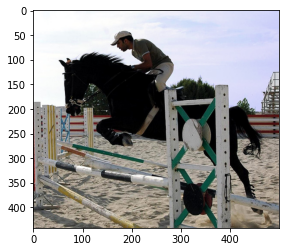

/gdrive/My Drive/Colab Notebooks/Lectures/085-088/utils085/data_augumentation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


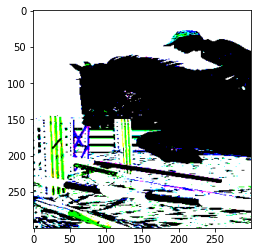

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


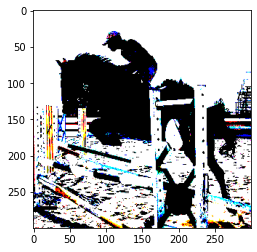

In [32]:
# 동작 확인

# 1. 화상 읽기
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path)  # [높이][폭][색BGR]
height, width, channels = img.shape  # 화상의 크기 취득

# 2. 어노테이션을 리스트로
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. 원래 화상을 표시
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 전처리 클래스 작성
color_mean = (104, 117, 123)  # (BGR) 색상의 평균값
input_size = 300  # 화상의 input 사이즈를 300×300으로
transform = DataTransform(input_size, color_mean)

# 5. train화상의 표시
phase = "train"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


# 6. val화상의 표시
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


# Dataset 작성

In [33]:
# VOC2012의 Dataset을 작성
class VOCDataset(data.Dataset):
    """
    VOC2012의 Dataset을 만드는 클래스. PyTorch의 Dataset 클래스를 상속받는다.

    Attributes
    ----------
    img_list : 리스트
        화상의 경로를 저장한 리스트
    anno_list : 리스트
        어노테이션의 경로를 저장한 리스트
    phase : 'train' or 'test'
        학습 또는 훈련을 설정한다.
    transform : object
        전처리 클래스의 인스턴스
    transform_anno : object
        xml 어노테이션을 리스트로 변환하는 인스턴스
    """

    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase  # train 또는 val을 지정
        self.transform = transform  # 화상의 변형
        self.transform_anno = transform_anno  # 어노테이션 데이터를 xml에서 리스트로 변경

    def __len__(self):
        '''화상의 매수를 반환'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        전처리한 화상의 텐서 형식 데이터와 어노테이션을 취득
        '''
        im, gt, h, w = self.pull_item(index)
        return im, gt

    def pull_item(self, index):
        '''전처리한 화상의 텐서 형식 데이터, 어노테이션, 화상의 높이, 폭을 취득한다'''

        # 1. 화상 읽기
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [높이][폭][색BGR]
        height, width, channels = img.shape  # 화상의 크기 취득

        # 2. xml 형식의 어노테이션 정보를 리스트에 저장
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)

        # 3. 전처리 실시
        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4])

        # 색상 채널의 순서가 BGR이므로 RGB로 순서를 변경
        # 또한 (높이, 폭, 색상 채널)의 순서를 (색상 채널, 높이, 폭)으로 변경
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

        # BBox와 라벨을 세트로 한 np.array를 작성, 변수 이름 "gt"는 ground truth의 약칭
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return img, gt, height, width


In [34]:
# 동작 확인
color_mean = (104, 117, 123)  # (BGR) 색의 평균값
input_size = 300  # 화상의 input 사이즈를 300×300으로 함

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))


# 데이터 출력의 예
val_dataset.__getitem__(1)


(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9082,  -13.2200,
             -9.4034],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9501,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2816,  -20.1750,   -5.5633,  ..., -104.9934, -111.8350,
           -119.0000],
          [ -20.4766,  -21.0000,  -12.6334,  ..., -107.1685, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0766,  -14.7250,
            -11.8534],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5016,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9501,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2

# DataLoader 작성

In [35]:
def od_collate_fn(batch):
    """
    Dataset에서 꺼내는 어노테이션 데이터의 크기는 화상마다 다릅니다.
    화상 내의 물체 수가 2개이면 (2, 5) 이지만, 3개이면 (3, 5) 등으로 변화합니다.
    이러한 변화에 대응한 DataLoader을 작성하기 위해 커스터마이즈한 collate_fn을 만듭니다.
    collate_fn은 PyTorch 리스트로 mini-batch를 작성하는 함수입니다.
    미니 배치 분량의 화상이 나열된 리스트 변수 batch에 미니 배치 번호를 지정하는 차원을 선두에 하나 추가하여 리스트의 형태를 바꿉니다.
    """

    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])  # sample[0]은 화상img입니다
        targets.append(torch.FloatTensor(sample[1]))  # sample[1]은 어노테이션 gt입니다

    # imgs는 미니 배치 크기의 리스트입니다
    # 리스트의 요소는 torch.Size([3, 300, 300]) 입니다
    # 이 리스트를 torch.Size([batch_num, 3, 300, 300])의 텐서로 변환합니다
    imgs = torch.stack(imgs, dim=0)

    # targets은 어노테이션의 정답인 gt의 리스트입니다
    # 리스트의 크기는 미니 배치의 크기가 됩니다
    # targets 리스트의 요소는 [n, 5] 로 되어 있습니다
    # n은 화상마다 다르며, 화상 속 물체의 수입니다
    # 5는 [xmin, ymin, xmax, ymax, class_index] 입니다

    return imgs, targets


In [37]:
# 데이터 로더 작성

batch_size = 4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 사전형 변수에 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["val"])  # 반복자로 변환
images, targets = next(batch_iterator)  # 첫 번째 요소를 추출
print(images.size())  # torch.Size([4, 3, 300, 300])
print(len(targets))
print(targets[1].size())  # 미니 배치 크기의 리스트, 각 요소는 [n, 5], n은 물체 수


torch.Size([4, 3, 300, 300])
4
torch.Size([2, 5])


In [38]:
print(train_dataset.__len__())
print(val_dataset.__len__())


5717
5823


끝